# Sea Ice Extent

This notebook downloads and renders a current graph of the global sea ice extent that begins in 1979 until now (may with 1 day delay or based on availability of the raw data from the [NSIDC](http://nsidc.org/arcticseaicenews/)). It is a real time data.

The Arctic and Antarctic SIC data can be downloaded respectively from<br> 
[ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv)<br>
[ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv](ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv). However, sometimes you may have to download them manually as their names may change with versions. The two datasets would be combined togeter to get global SIC during the procedure of analysis.

This notebook is inspired by the tutorials from [Emma M](https://github.com/emmatoday/PyClimateGraphs), and all credit goes to Emma M. Besides this notebook only puts original notebooks for Arctic, Antarctic an Global SICs into a single one, the source code is adjusted a little bit to run smoothly under python 2.7. In addition, the data links are updated to the latest version of v3.0.

## 1. Load all needed libraries

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import os
import calendar
import urllib2
import urlparse

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 6

## 2. Set up some constants

In [2]:
LOCAL_DATA_PATH = '.\data'
LOCAL_OUTPUT_PATH = '.\image'
DATA_URLS = {
    's': 'ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/daily/data/S_seaice_extent_daily_v3.0.csv',
    'n': 'ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/daily/data/N_seaice_extent_daily_v3.0.csv'
}

pd.set_option('display.max_rows', 5)

## 3. Update SIC data

### 3.1 Customized file operation functions

Prepare and load the data files. Downloading and updating as necessary

In [3]:
# Check if necessary directories exist
def mkdir_if_necessary(dir):
    try:
        os.stat(dir)
    except:
        os.mkdir(dir)       

# Check if our data files exist already
def data_files_exist():
    for key, url in DATA_URLS.items():
        filename = os.path.split(urlparse.urlsplit(url).path)[-1]
        if os.path.isfile(os.path.join(LOCAL_DATA_PATH, filename)):
            return True
        else:
            return False

# Load the data from disk and return the dataframes
def load_data_files():
    sea_ice_indexes = {}
    for key, url in DATA_URLS.items():
        filename = os.path.split(urlparse.urlsplit(url).path)[-1]
        sea_ice_indexes[key] = pd.read_csv(os.path.join(LOCAL_DATA_PATH, filename), skiprows=[1])
    for key in sea_ice_indexes.keys():
        sea_ice_indexes[key].rename(columns=lambda x: x.strip(), inplace=True)
        sea_ice_indexes[key]['Date'] = sea_ice_indexes[key].apply(lambda row: datetime.date(
                                       row['Year'], row['Month'], row['Day']), axis=1)
        sea_ice_indexes[key]['Day of Year'] = sea_ice_indexes[key].apply(lambda row: row['Date'].timetuple().tm_yday, axis=1)
        sea_ice_indexes[key]['Date'] = pd.to_datetime(sea_ice_indexes[key]['Date'])
    sea_ice_indexes['n'] = sea_ice_indexes['n'][['Extent', 'Date']]
    sea_ice_indexes['s'].rename(columns={'Extent': 'S Extent'}, inplace=True)
    sea_ice_indexes['n'].rename(columns={'Extent': 'N Extent'}, inplace=True)
    return sea_ice_indexes
        
# Check if our data appears to be out of date
def data_is_fresh(sea_ice_indexes):
    for key, sea_ice_index in sea_ice_indexes.items():
        today = datetime.date.today()
        print('Data is {0} day(s) old'.format((datetime.datetime.now() - sea_ice_index['Date'].iloc[-1]).days))
        if (datetime.datetime.now() - sea_ice_index['Date'].iloc[-1]).days >= 2:
            return False
        else:
            return True

# Update to latest data files
def refresh_data_files():
    for key, url in DATA_URLS.items():
        filename = os.path.join(LOCAL_DATA_PATH, os.path.split(urlparse.urlsplit(url).path)[-1])
        #with urllib.urlopen(url) as response, open(filename, 'wb') as out_file:
        #    shutil.copyfileobj(response, out_file)
        response = urllib2.urlopen(url)
        html = response.read()

        with open(filename, 'wb') as out_file:
            out_file.write(html)
    

# Prepare and load the data files downloading and updating as necessary
def prep_data_files():
    mkdir_if_necessary(LOCAL_DATA_PATH)
    mkdir_if_necessary(LOCAL_OUTPUT_PATH)

    if data_files_exist():
        print('Data files exist')
        sea_ice_indexes = load_data_files()
        if data_is_fresh(sea_ice_indexes):
            print('Data files are up to date')
        else:
            print('Data files are outdated')
            refresh_data_files()
            sea_ice_indexes = load_data_files()
            print('Data files have been updated')
    else:
        print('No data files found')
        refresh_data_files()
        sea_ice_indexes = load_data_files()
        print('Data files have been downloaded')
    return sea_ice_indexes

### 3.2 Load SIC data

In [4]:
sea_ice_indexes = prep_data_files()

Data files exist
Data is 2 day(s) old
Data files are outdated
Data files have been updated


In [5]:
global_sea_ice_index = pd.merge(left=sea_ice_indexes['s'],
                                right=sea_ice_indexes['n'],
                                on='Date')

global_sea_ice_index['Total Extent'] = global_sea_ice_index['S Extent'] + global_sea_ice_index['N Extent']
global_sea_ice_index.index = global_sea_ice_index['Day of Year']
global_sea_ice_index

,Year,Month,Day,S Extent,Missing,Source Data,Date,Day of Year,N Extent,Total Extent
Day of Year,,,,,,,,,,
299,1978,10,26,17.624,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,1978-10-26,299,10.231,27.855
301,1978,10,28,17.803,0.000,['ftp://sidads.colorado.edu/pub/DATASETS/nsid...,1978-10-28,301,10.420,28.223
...,...,...,...,...,...,...,...,...,...,...
295,2017,10,22,17.503,0.001,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,2017-10-22,295,7.512,25.015
296,2017,10,23,17.523,0.017,['ftp://sidads.colorado.edu/pub/DATASETS/nsidc...,2017-10-23,296,7.604,25.127


### 3.3 Simplify SIC data to only keep necessary variables

In [6]:
global_sea_ice_index.drop(['Missing','Source Data','Day','Date','Month', 'Day of Year'], axis=1, inplace=True)
global_sea_ice_index.index = global_sea_ice_index.index.astype(datetime.datetime)

global_sea_ice_index

,Year,S Extent,N Extent,Total Extent
Day of Year,,,,
299,1978,17.624,10.231,27.855
301,1978,17.803,10.420,28.223
...,...,...,...,...
295,2017,17.503,7.512,25.015
296,2017,17.523,7.604,25.127


## 4. Arctic SIC

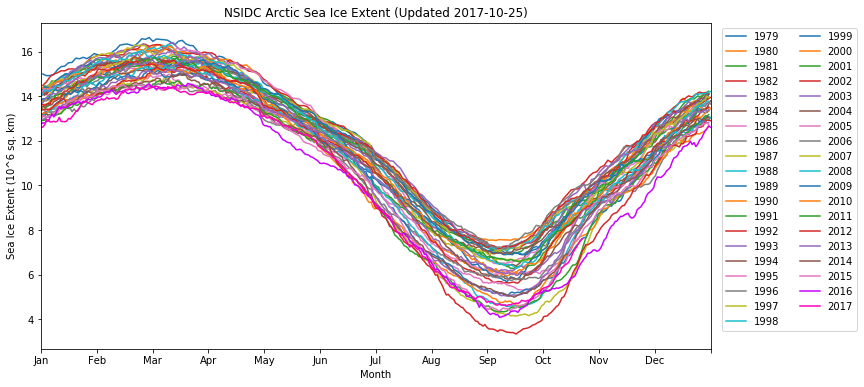

In [7]:
for key, grp in global_sea_ice_index.groupby(['Year']):
    if (key >= 1979 and key <= 2018) or key >= 2016:
        if key == 2017:
            plt.plot(grp['N Extent'], label=key, color="#ff00bb")
        elif key == 2016:
            plt.plot(grp['N Extent'], label=key, color="#cc00ff")
        else:
            plt.plot(grp['N Extent'], label=key)

plt.title('NSIDC Arctic Sea Ice Extent (Updated {0})'.format(datetime.date.today().isoformat()))
plt.xlabel("Month")
plt.xlim(1,366)
plt.xticks(np.linspace(1,366,13), calendar.month_abbr[1:13], rotation=0)
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.01, 1), ncol=2, fontsize=10)
plt.ylabel("Sea Ice Extent (10^6 sq. km)")

plt.savefig(r'image\arctic_sea_ice_{0}.png'.format(datetime.date.today().isoformat()),
        dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None)

## 5. Antarctic SIC

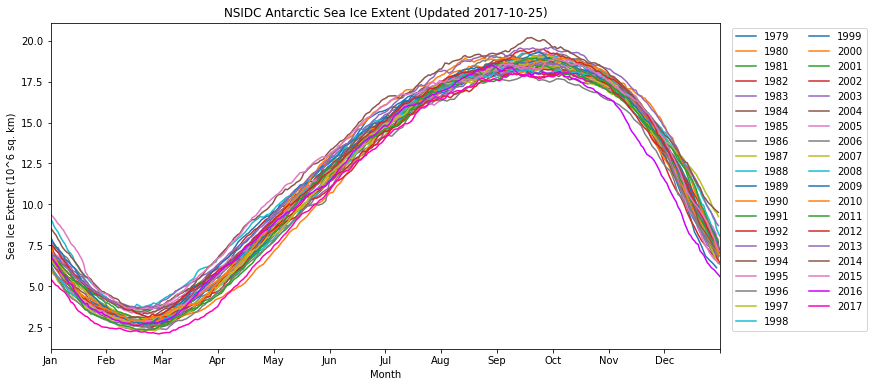

In [8]:
for key, grp in global_sea_ice_index.groupby(['Year']):
    if (key >= 1979 and key <= 2018) or key >= 2016:
        if key == 2017:
            plt.plot(grp['S Extent'], label=key, color="#ff00bb")
        elif key == 2016:
            plt.plot(grp['S Extent'], label=key, color="#cc00ff")
        else:
            plt.plot(grp['S Extent'], label=key)

plt.title('NSIDC Antarctic Sea Ice Extent (Updated {0})'.format(datetime.date.today().isoformat()))
plt.xlabel("Month")
plt.xlim(1,366)
plt.xticks(np.linspace(1,366,13), calendar.month_abbr[1:13], rotation=0)
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.01, 1), ncol=2, fontsize=10)
plt.ylabel("Sea Ice Extent (10^6 sq. km)")

plt.savefig(r'image\antarctic_sea_ice_{0}.png'.format(datetime.date.today().isoformat()),
        dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None)

## 6. Global SIC

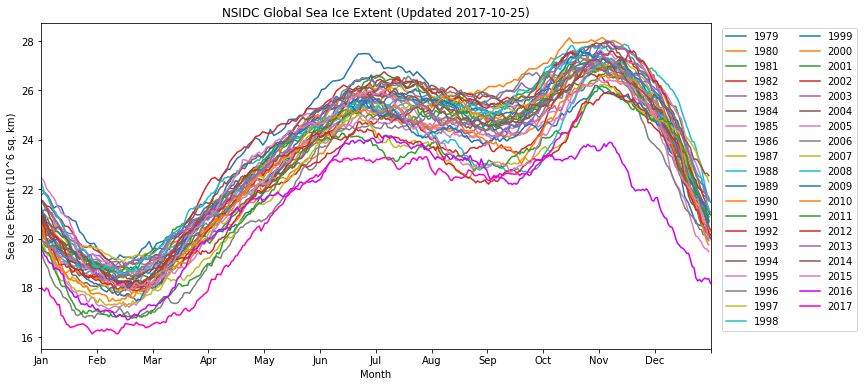

In [9]:
for key, grp in global_sea_ice_index.groupby(['Year']):
    if (key >= 1979 and key <= 2018) or key >= 2016:
        if key == 2017:
            plt.plot(grp['Total Extent'], label=key, color="#ff00bb")
        elif key == 2016:
            plt.plot(grp['Total Extent'], label=key, color="#cc00ff")
        else:
            plt.plot(grp['Total Extent'], label=key)

plt.title('NSIDC Global Sea Ice Extent (Updated {0})'.format(datetime.date.today().isoformat()))
plt.xlabel("Month")
plt.xlim(1,366)
plt.xticks(np.linspace(1,366,13), calendar.month_abbr[1:13], rotation=0)
plt.legend(loc='best')
plt.legend(bbox_to_anchor=(1.01, 1), ncol=2, fontsize=10)
plt.ylabel("Sea Ice Extent (10^6 sq. km)")

output_filename = 'global_sea_ice_{0}.png'.format(datetime.date.today().isoformat())
output_path = os.path.join(LOCAL_OUTPUT_PATH, output_filename)

plt.savefig(output_path,
        dpi=300, facecolor='w', edgecolor='w',
        orientation='portrait', papertype=None, format='png',
        transparent=False, bbox_inches='tight', pad_inches=0.1,
        frameon=None)

## Summary of SIC in October, 2017

After setting a record low seasonal maximum in early March, Arctic sea ice extent continued to track low through July. However, the rate of ice loss slowed in August and September. The daily minimum extent, reached on September 13, was the eighth lowest on record, while the monthly average extent was seventh lowest. In Antarctica, sea ice extent may have reached its annual winter maximum.

More information can be found at http://nsidc.org/arcticseaicenews/.